In [1]:
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import mpld3
mpld3.enable_notebook()
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_style("whitegrid")

import os
os.environ['JCMPYTHON_CONFIG_FILE'] = '../local/config.cfg'

import sys
sys.path.append('..')
import jcmpython as jpy
import numpy as np
jpy.load_extension('antenna')

#project = jpy.JCMProject('antennaExample')

[INFO] init: Writing logs to file: /home/niko/jcmpython/local/logs/160909.log
[INFO] init: Imported jcmwave from: /opt/JCM_3.0.14
[INFO] init: Loaded extension: antenna


In [2]:
project = jpy.JCMProject('/home/niko/jcmpython/projects/scattering/mie/mie2D_rot')

In [3]:
keys = {'constants':{},
        'parameters':{},
        'geometry':{}}

In [4]:
simuset = jpy.SimulationSet(project, keys)
simuset.make_simulation_schedule()

[INFO] core.SimulationSet: Using folder /home/niko/jcmpython/local/160909 for data storage.
[INFO] core.SimulationSet: Performing a single simulation


In [5]:
own_antenna = jpy.antenna()
own_antenna.generatePostProcess(simuset.project.get_project_file_path())

simuset.solve_single_simulation(0,run_post_process_files=own_antenna.filePaths)
simuset.simulations[0].process_results(processing_func=jpy.antenna.read_fullFarField, overwrite=True)


[WARNING] py.warnings: ../jcmpython/parallelization.py:228: RuntimeWarning: Ignoring deprecated argument "JCMKERNEL".
  **self.kwargs)



In [6]:
own_antenna._geometry

'2D'

In [7]:
own_antenna.full_directivity(simuset.simulations[0]._results_dict)

<IPython.core.display.Javascript object>


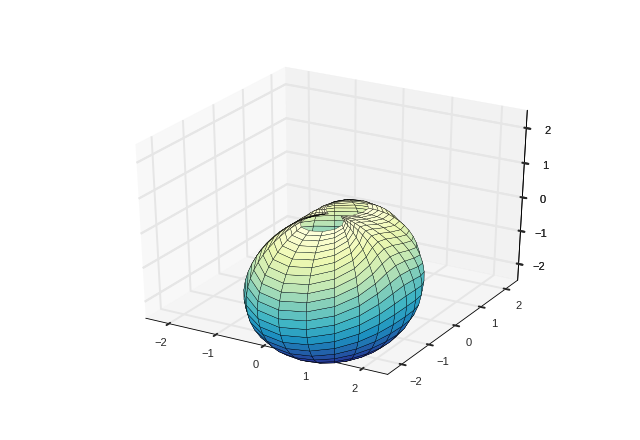

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(own_antenna.directivity_up[0].real,
                own_antenna.directivity_up[1].real,
                own_antenna.directivity_up[2].real,
                rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r)

ax.plot_surface(own_antenna.directivity_down[0].real,
                own_antenna.directivity_down[1].real,
                own_antenna.directivity_down[2].real,
                rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r)

dist = 4
ax.set_xlim([-dist*.6,dist*.6])
ax.set_ylim([-dist*.6,dist*.6])
ax.set_zlim([-dist*.6,dist*.6]);

<IPython.core.display.Javascript object>


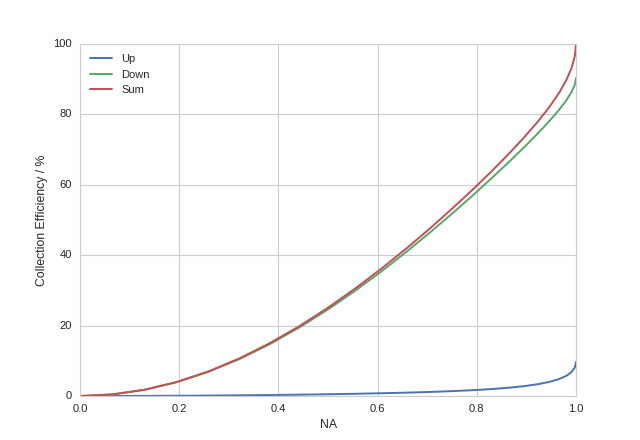

In [9]:
plt.figure()
powerUp = own_antenna.ffp_up/own_antenna.ffp*100
powerDown = own_antenna.ffp_down/own_antenna.ffp*100
plt.plot(own_antenna.NA_up,powerUp,label='Up')
plt.plot(own_antenna.NA_down,powerDown,label='Down')
plt.plot(own_antenna.NA_up,powerUp+list(reversed(powerDown)),label='Sum')
plt.xlabel('NA')
plt.ylabel('Collection Efficiency / %')
plt.legend(loc='best');